# Aim of the the project:

1. Calculating landcover distribution in our wetlands based on 10 m landcover map of Sweden
2. Open water and flooded vegetation extraction in one of our wetlands.

## Calculating landcover distribution
we use two different layer:
1. [National landcover map of Sweden in 10m resolution](https://www.swedishepa.se/State-of-the-environment/Maps-and-map-services/National-Land-Cover-Database/) ( left picture)
2. [vector layer of Ramsar sites in Sweden](https://rsis.ramsar.org/ris-search/?f[0]=regionCountry_en_ss%3ASweden) ( right picture)

<img src='picture1.png' width="400">   <img src='picture2.png' width="400">

In [100]:
%%bash
gdalinfo nmd2018bas_ogeneraliserad_v1_1.tif | more

Driver: GTiff/GeoTIFF
Files: nmd2018bas_ogeneraliserad_v1_1.tif
Size is 71273, 157992
Coordinate System is:
PROJCS["SWEREF99 TM",
    GEOGCS["SWEREF99",
        DATUM["SWEREF99",
            SPHEROID["GRS 1980",6378137,298.257222101,
                AUTHORITY["EPSG","7019"]],
            TOWGS84[0,0,0,0,0,0,0],
            AUTHORITY["EPSG","6619"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","4619"]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["latitude_of_origin",0],
    PARAMETER["central_meridian",15],
    PARAMETER["scale_factor",0.9996],
    PARAMETER["false_easting",500000],
    PARAMETER["false_northing",0],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]],
    AUTHORITY["EPSG","3006"]]
Origin = (208450.000000000000000,7671060.000000000000000)
Pixel Size = (10.000000000000000,-10.000000000000000)
Metadata:
  AREA_OR_POINT=Area
  TIFFT

As NoData Value is not assigned, we assign nodata value = 0

In [102]:
%%bash
gdal_edit.py -a_nodata 0 nmd2018bas_ogeneraliserad_v1_1.tif

we create the shapefile of each wetland by using ```$ split vector layer``` tool in QGIS to clip our landcover by this layers

In [104]:
%%bash
for file in rms/*.gpkg; do echo $file; filename=$(basename $file .gpkg); gdalwarp -overwrite -srcnodata 0 -dstnodata 0 -crop_to_cutline -cutline $file nmd2018bas_ogeneraliserad_v1_1.tif clipped/${filename}.tif; done

rms/ramsarid_1113.gpkg
Copying color table from nmd2018bas_ogeneraliserad_v1_1.tif to new file.
Creating output file that is 2623P x 1832L.
Processing nmd2018bas_ogeneraliserad_v1_1.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
rms/ramsarid_1114.gpkg
Copying color table from nmd2018bas_ogeneraliserad_v1_1.tif to new file.
Creating output file that is 2745P x 1850L.
Processing nmd2018bas_ogeneraliserad_v1_1.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
rms/ramsarid_1115.gpkg
Copying color table from nmd2018bas_ogeneraliserad_v1_1.tif to new file.
Creating output file that is 4953P x 1980L.
Processing nmd2018bas_ogeneraliserad_v1_1.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
rms/ramsarid_1116.gpkg
Copying color table from nmd2018bas_ogeneraliserad_v1_1.tif to new file.
Creating output file that is 2032P x 3435L.
Processing nmd2018bas_ogeneraliserad_v1_1.tif [1/1] : 0...10...20...30...40...50...60...70...80

Now that we have our clipped land cover we can calculate the histogram (in percentage)

In [6]:
%%bash
for file in clipped/*.tif; do echo $file; filename=$(basename $file .tif); pkstat -hist -rel -src_min 2 -src_max 128 -i $file > hist/${filename}.txt; done

clipped/ramsarid_436_clip.tif


Now we have the text file of our histograms we can extract our desired classes for each of our 67 wetlands
- we have 25 classess in total
- 7 of the classess are our main interest

<img src='picture3.png' width="500"> 

Extract all 25 classes

In [7]:
%%bash
#printf "%s %.3f\n", $1, $2
for file in hist/*.txt; do echo $file; filename=$(basename $file .txt);
awk '{ if($1==111||$1==112||$1==113||$1==114||$1==115||$1==116||$1==117||$1==118||$1==121||$1==122||$1==123||$1==124||$1==125||$1==126||$1==127||$1==128||$1==2||$1==3||$1==41||$1==42||$1==51||$1==52||$1==53||$1==61||$1==62) print}' $file > class_25/${filename}.txt;done

hist/ramsarid_436_clip.txt


Extract 7 main classess of our interest

In [8]:
%%bash
for file in hist/*.txt; do echo $file; filename=$(basename $file .txt);
    awk '$1==111 || $1==112 || $1==113 || $1==114 ||$1==115 || $1==116 ||$1==117 || $1==118 {sum1+= $2} 
$1==121 || $1==122 || $1==123 || $1==124 ||$1==125 || $1==126 ||$1==127 || $1==128 {sum2+= $2} 
$1==2 {sum3+= $2} 
$1==3 {sum4+= $2} 
$1==41 || $1==42 {sum5+= $2} 
$1==51 || $1==52 || $1==53 {sum6+= $2} 
$1==61 || $1==62 {sum7+= $2} 
END{print ("1.1 "sum1); print ("1.2 "sum2); print("2 "sum3); print("3 "sum4); print("4 "sum5); print("5 "sum6); print("6 "sum7)}' $file > class_7/${filename}.txt;done

hist/ramsarid_436_clip.txt


In [9]:
%%bash
for file in class_7/*.txt; do echo $file; filename=$(basename $file .txt);
awk 'BEGIN{print "Class Ratio"}1' $file > head/${filename}.txt; done #The 1 is to indicate to print every line of the file.

class_7/ramsarid_436_clip.txt


In [76]:
pip install matplotlib

     |████████████████████████████████| 10.3 MB 7.9 MB/s eta 0:00:01
     |████████████████████████████████| 3.0 MB 17.5 MB/s eta 0:00:01
     |████████████████████████████████| 1.2 MB 54.3 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


ramsarid_1113


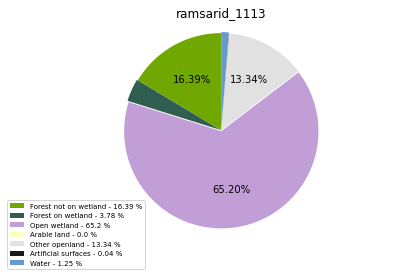

ramsarid_1114


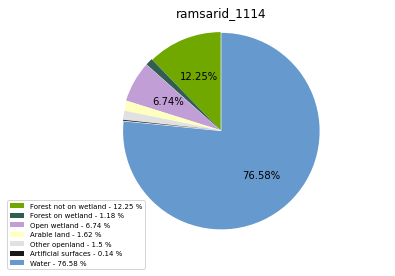

ramsarid_1115


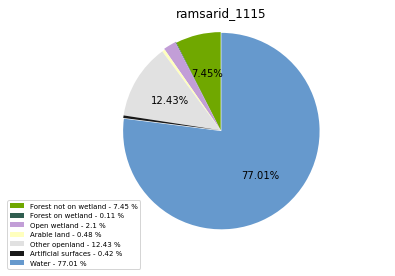

ramsarid_1116


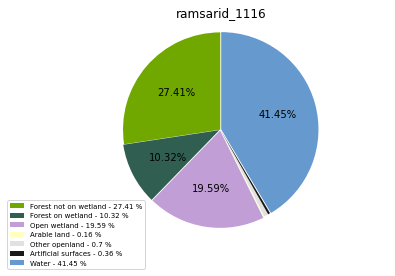

ramsarid_1117


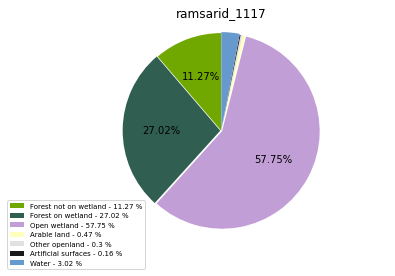

ramsarid_1118


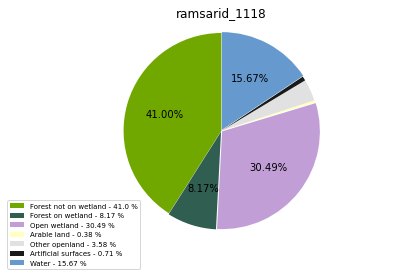

ramsarid_1119


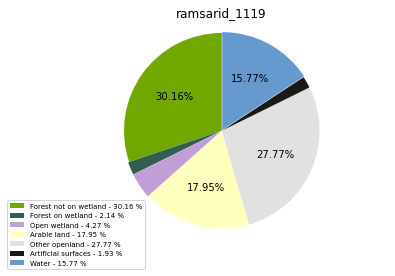

ramsarid_1120


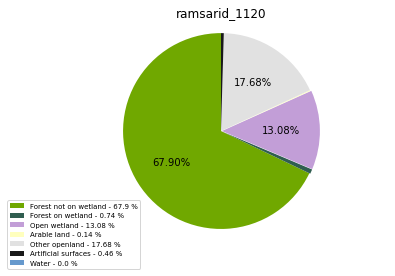

ramsarid_1121


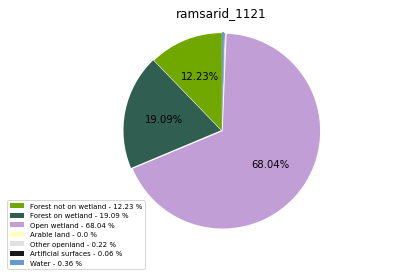

ramsarid_1122


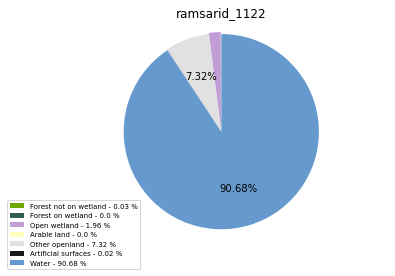

ramsarid_1123


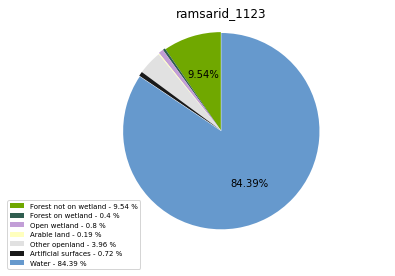

ramsarid_1124


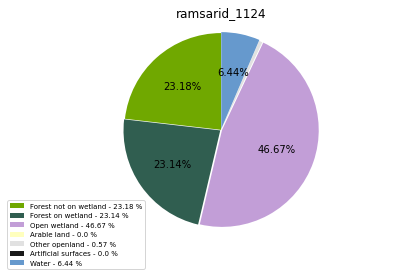

ramsarid_1125


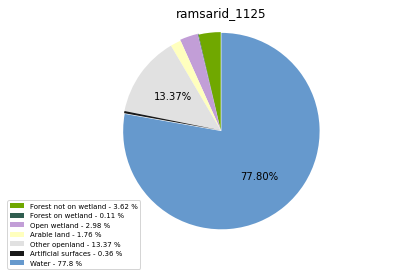

ramsarid_1126


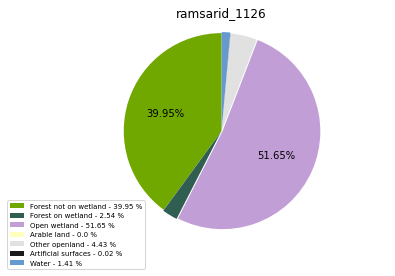

ramsarid_1127


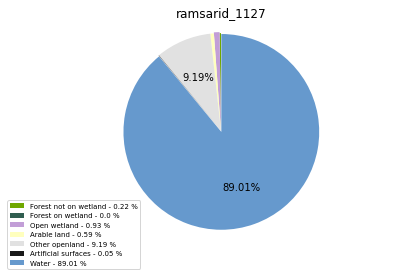

ramsarid_1128


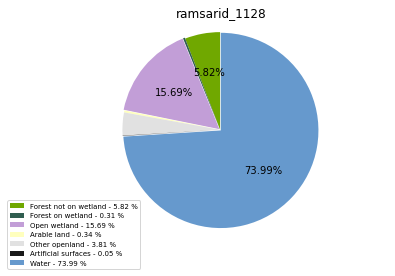

ramsarid_1129


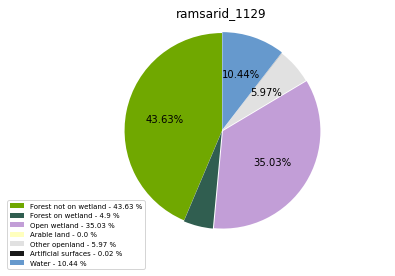

ramsarid_1130


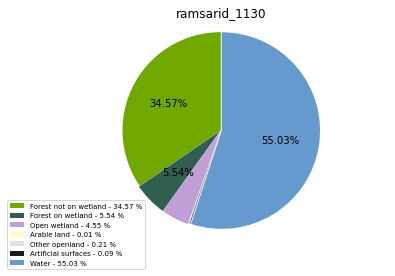

ramsarid_1131


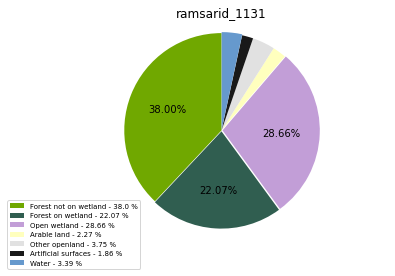

ramsarid_1132


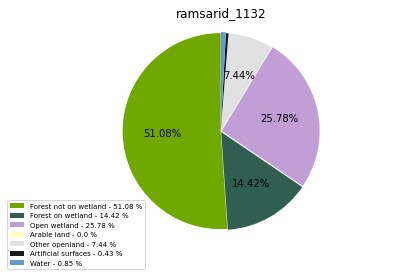

ramsarid_1133


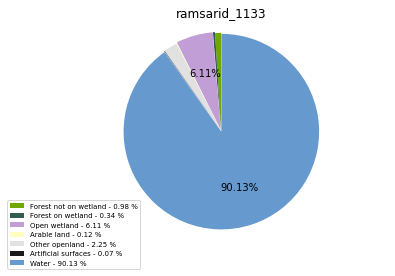

ramsarid_14


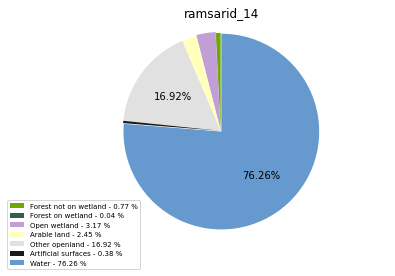

ramsarid_15


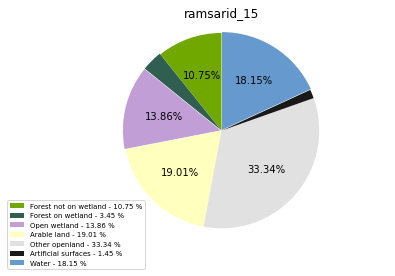

ramsarid_16


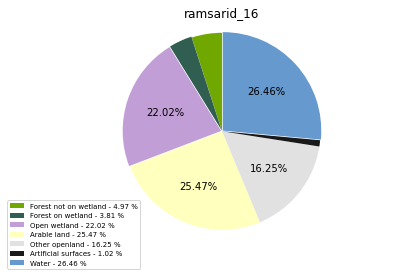

ramsarid_17


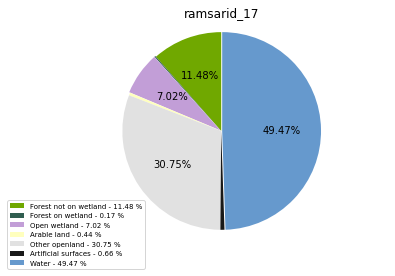

ramsarid_18


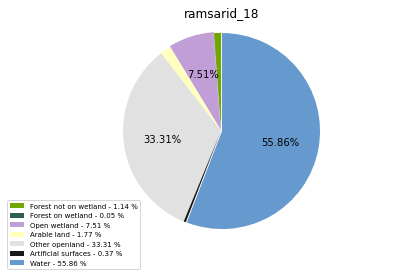

ramsarid_19


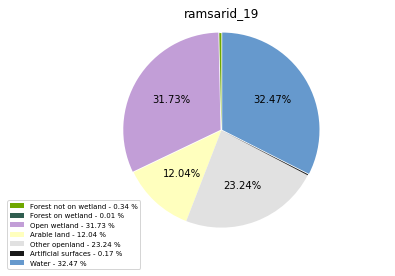

ramsarid_20


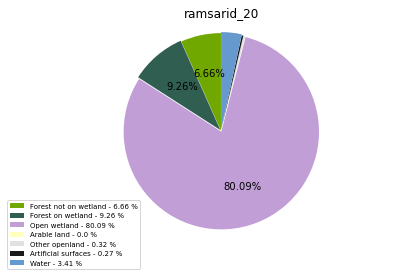

ramsarid_21


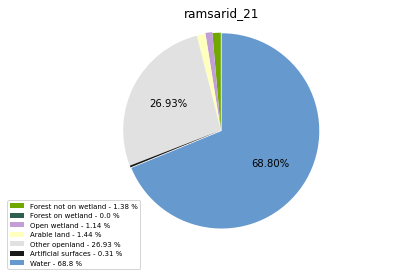

ramsarid_2167


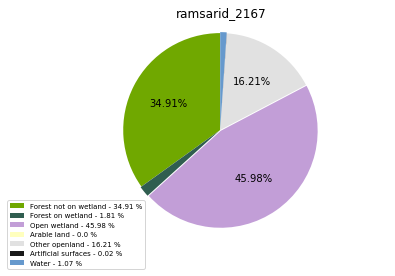

ramsarid_2168


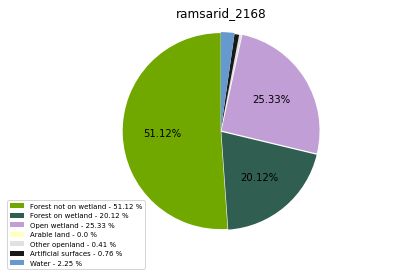

ramsarid_2169


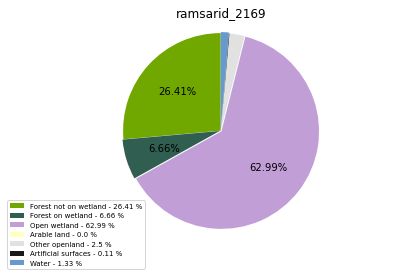

ramsarid_2170


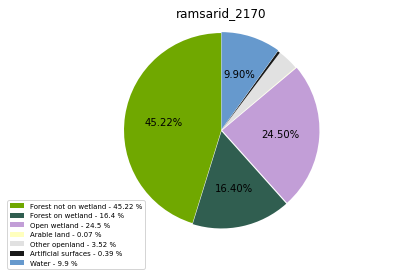

ramsarid_2171


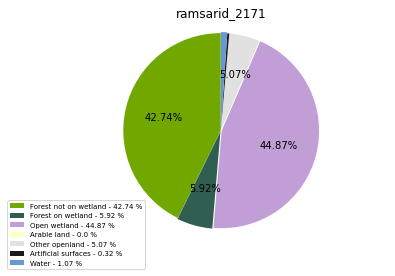

ramsarid_2172


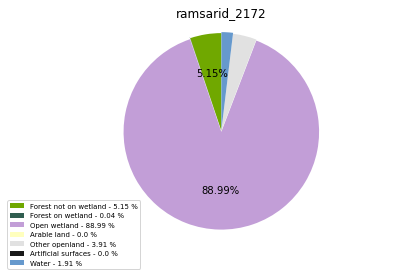

ramsarid_2173


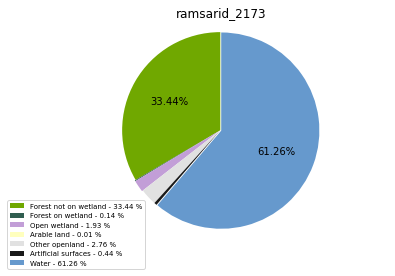

ramsarid_2174


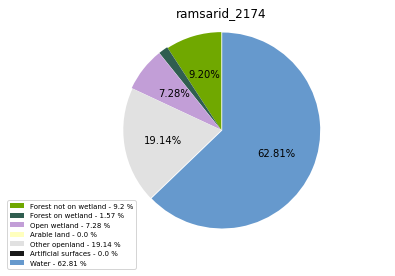

ramsarid_2175


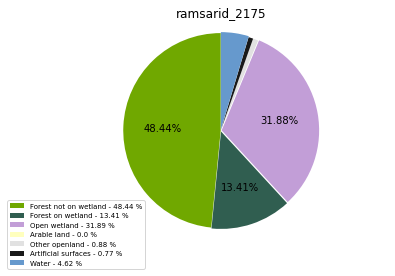

ramsarid_2176


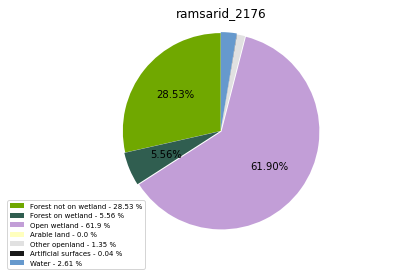

ramsarid_2177


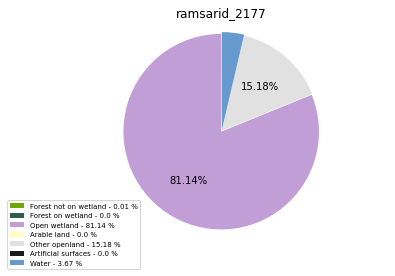

ramsarid_2178


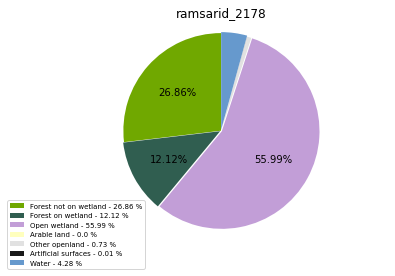

ramsarid_2179


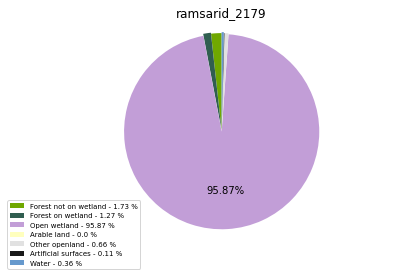

ramsarid_2180


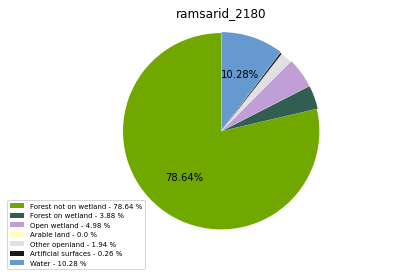

ramsarid_22


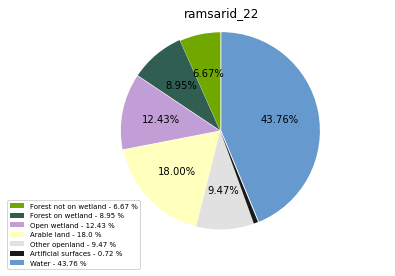

ramsarid_2260


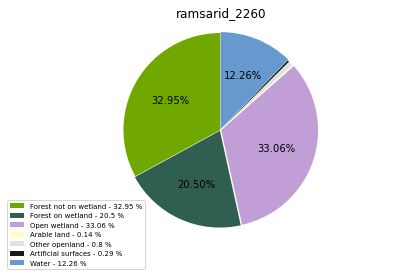

ramsarid_2265


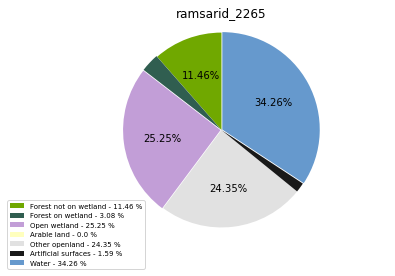

ramsarid_23


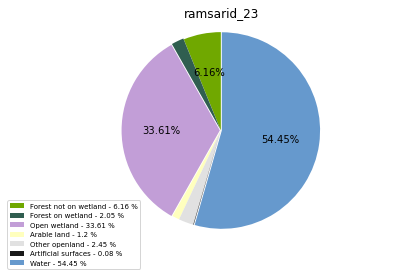

ramsarid_24


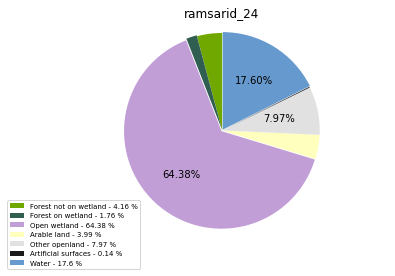

ramsarid_25


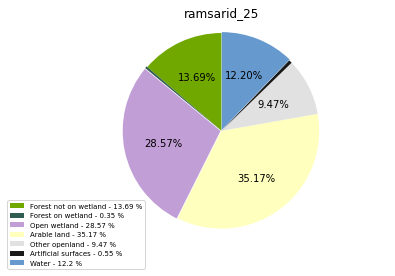

ramsarid_26


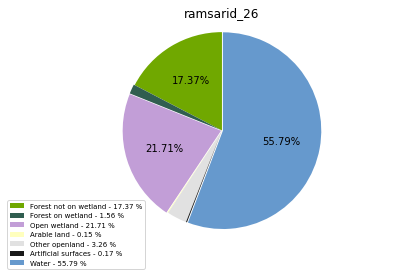

ramsarid_27


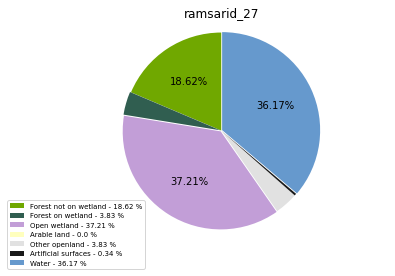

ramsarid_28


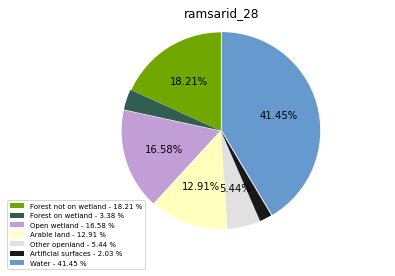

ramsarid_29


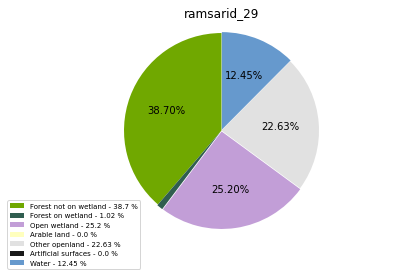

ramsarid_30


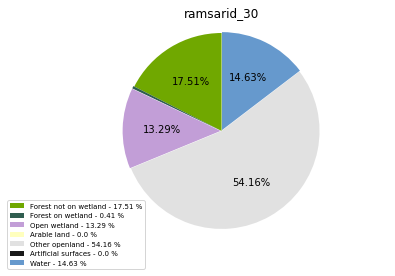

ramsarid_31


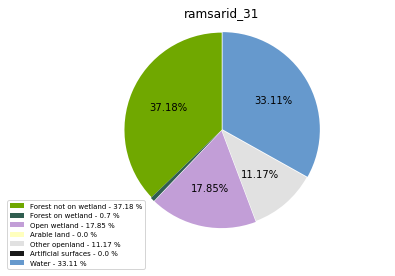

ramsarid_32


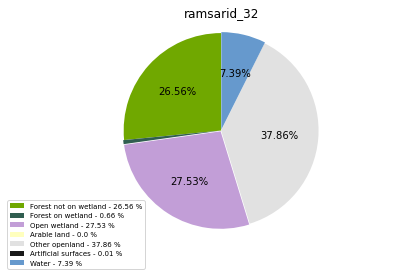

ramsarid_33


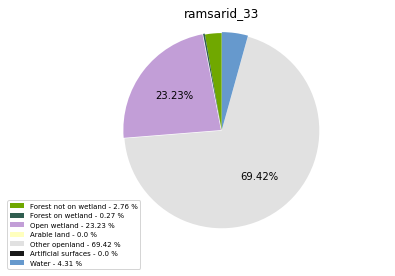

ramsarid_429


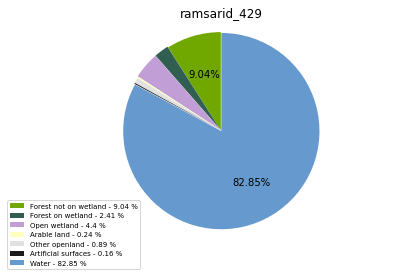

ramsarid_430


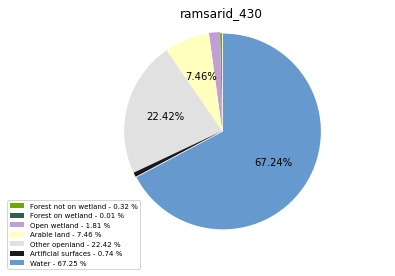

ramsarid_431


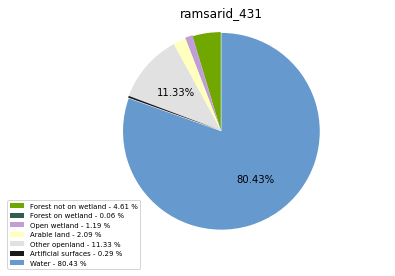

ramsarid_432


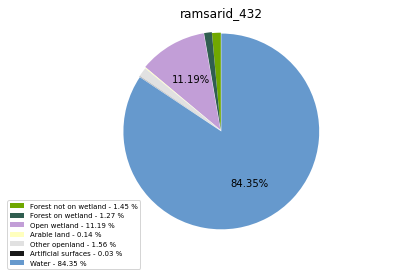

ramsarid_433


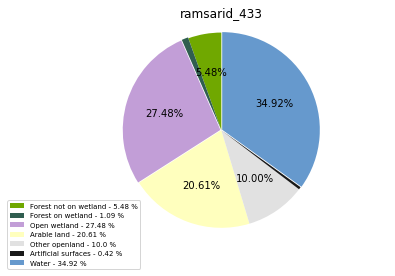

ramsarid_434


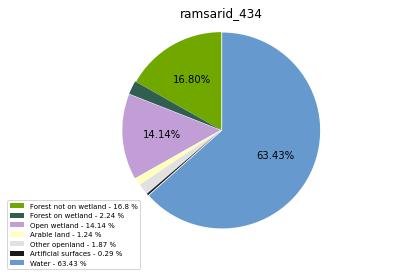

ramsarid_435


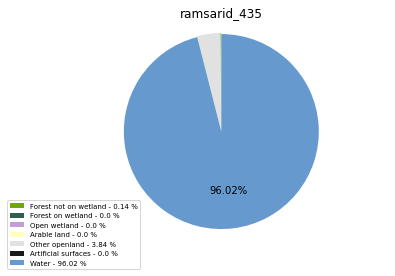

ramsarid_436


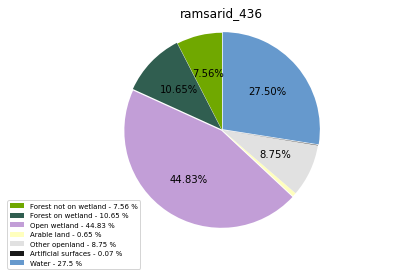

ramsarid_436_clip


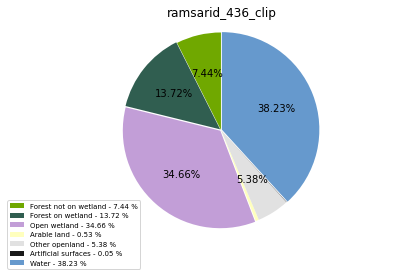

ramsarid_437


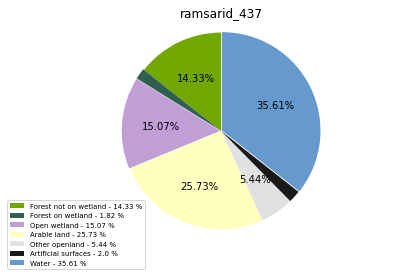

ramsarid_438


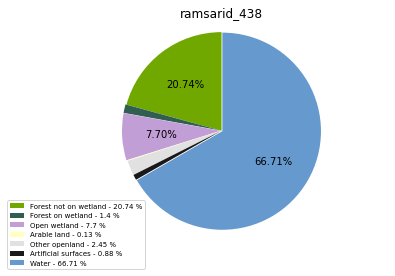

In [5]:
import matplotlib.pyplot as plt
import os
import glob

file_location = os.path.join('class_7', '*.txt')
filenames = glob.glob(file_location)


class_ = ['Forest not on wetland', 'Forest on wetland',
          'Open wetland','Arable land', 'Other openland', 'Artificial surfaces',
          'Water']

for f in filenames:
    ratio = []
    
    outfile = open(f,'r')
    for line in outfile:
    	Data = [i for i in line.split()]
    	New_Data= [ j for j in Data[1].split()]
    	ratio.append(New_Data[0])
    outfile.close()
    
    file_name = os.path.basename(f)
    file_name=os.path.splitext(file_name)[0]
    print(file_name)
    
    ratio = [float(i) for i in ratio]
    #print(ratio)
    colors = ['#70a800ff', '#305e50ff', '#c29ed7ff', '#ffffbeff','#e1e1e1ff', '#191919ff', '#6699cdff']
    explode = [0, 0.01, 0.01, 0, 0, 0, 0.01]
    # plotting pie chart
    def my_autopct(pct):
        return ('%.2f%%' % pct) if pct > 5 else ''
    
    plt.pie(ratio, colors = colors, startangle = 90, explode = explode,
    		 shadow = False, autopct=my_autopct )
    
    plt.title(label=file_name,  loc='center')
    ratio_r =  [round(num, 2) for num in ratio]
    labels = ['{0} - {1} %'.format(i, j) for i, j in zip(class_,ratio_r)]
    plt.legend( labels, loc='lower left', bbox_to_anchor=(-0.15, -.15), fontsize=7)
    plt.axis('equal')
    #plt.tight_layout()
    file_name_ext=os.path.splitext(file_name)[0]+".svg"
    plt.savefig(file_name_ext, format="svg", dpi=500)
    plt.show()
    


## Open water and flooded vegetation extraction


### Open water extraction
- Layers: SAR intensity sentinel-1 image. 

<img src='picture4.png' width="400"> 

data source: [Google Earth Engine](https://code.earthengine.google.com)
         
          
we use thresholding method to extract open water from S1 layer 

First we move all layers to the crs: EPSG:4326

In [109]:
%%bash
rm --force layers_reprj/*.tif
for file in layers/*.tif; do echo $file; filename=$(basename $file .tif);
gdalwarp -ot "Float32" -t_srs EPSG:4326 $file layers_reprj/${filename}_reprj.tif;done

layers/coherence.tif
Creating output file that is 15046P x 4166L.
Processing layers/coherence.tif [1/1] : 0Using internal nodata values (e.g. -3.4e+38) for image layers/coherence.tif.
Copying nodata values from source layers/coherence.tif to destination layers_reprj/coherence_reprj.tif.
...10...20...30...40...50...60...70...80...90...100 - done.
layers/S2.tif
Creating output file that is 3119P x 1352L.
Processing layers/S2.tif [1/1] : 0Using internal nodata values (e.g. -3.4e+38) for image layers/S2.tif.
Copying nodata values from source layers/S2.tif to destination layers_reprj/S2_reprj.tif.
...10...20...30...40...50...60...70...80...90...100 - done.
layers/SAR_VH.tif
Creating output file that is 3119P x 1352L.
Processing layers/SAR_VH.tif [1/1] : 0Using internal nodata values (e.g. -3.4e+38) for image layers/SAR_VH.tif.
Copying nodata values from source layers/SAR_VH.tif to destination layers_reprj/SAR_VH_reprj.tif.
...10...20...30...40...50...60...70...80...90...100 - done.
layers/s

In [111]:
%%bash 
#applying nodata value equal to zero
for file in layers/*.tif; do echo $file; 
gdal_edit.py -a_nodata -3.39999995214436425e+38 $file;done

layers/coherence.tif
layers/S2.tif
layers/SAR_VH.tif
layers/slope.tif


In [1]:
%%bash
rm --force crop/*.tif
for file in layers/*.tif; do echo $file; 
  filename=$(basename $file .tif)
  gdalwarp -overwrite -te 14.6714649 58.2914991 14.9516494 58.4129513 -tr 0.000269494585236 -0.000269494585236 $file crop/${filename}_crop.tif 
done

layers/coherence.tif
Creating output file that is 1040P x 451L.
Processing layers/coherence.tif [1/1] : 0Using internal nodata values (e.g. -3.4e+38) for image layers/coherence.tif.
Copying nodata values from source layers/coherence.tif to destination crop/coherence_crop.tif.
...10...20...30...40...50...60...70...80...90...100 - done.
layers/S2.tif
Creating output file that is 1040P x 451L.
Processing layers/S2.tif [1/1] : 0Using internal nodata values (e.g. -3.4e+38) for image layers/S2.tif.
Copying nodata values from source layers/S2.tif to destination crop/S2_crop.tif.
...10...20...30...40...50...60...70...80...90...100 - done.
layers/SAR_VH.tif
Creating output file that is 1040P x 451L.
Processing layers/SAR_VH.tif [1/1] : 0Using internal nodata values (e.g. -3.4e+38) for image layers/SAR_VH.tif.
Copying nodata values from source layers/SAR_VH.tif to destination crop/SAR_VH_crop.tif.
...10...20...30...40...50...60...70...80...90...100 - done.
layers/slope.tif
Creating output file t

we maskout values greater than **-23** 

<img src='picture5.png' width="400"> 

In [ ]:
%%bash
pkgetmask -max -23 -data 2 -nodata 0 -ot Byte -i crop/SAR_VH_crop.tif -o crop/water.tif;
gdalwarp -crop_to_cutline -cutline rms/ramsarid_23.gpkg crop/water.tif  crop/wat.tif; 

### Flooded vegetation extraction by using unsupervised Kmean classification
- Layers: 1. Coherence layer ( left picture)
          2. slope layer (generated from SRTM DEM (right picture)

<img src='picture6.png' width="400">  <img src='picture7.png' width="400"> 

orfeo kmean clustering toolbox could not handle **nan** values and alsso give us warning for **nodatavalue=-3.39999995214436425e+38** 
by the following code we solve this two problems

In [142]:
%%bash
#crop the coherence, SAR, and slope .tif files by our wetland shape of interest to exclude the nan values
gdalwarp -crop_to_cutline -overwrite -srcnodata -3.39999995214436425e+38 -dstnodata -999 -cutline rms/ramsarid_23.gpkg crop/slope_crop.tif  crop/slope_crop_ready.tif; 
gdalwarp -crop_to_cutline -overwrite -srcnodata -3.39999995214436425e+38 -dstnodata -999 -cutline rms/ramsarid_23.gpkg crop/coherence_crop.tif  crop/coherence_crop_ready.tif 

Creating output file that is 792P x 254L.
Processing crop/slope_crop.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 792P x 254L.
Processing crop/coherence_crop.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


We want to build stack of 2 layers before doing unsupervised classification: **SAR coherence** and **SRTM DEM**

In [143]:
%%bash
# stck the tif
gdalbuildvrt -overwrite -separate crop/stack.vrt crop/coherence_crop_ready.tif crop/slope_crop_ready.tif
gdalinfo -mm crop/stack.vrt

0...10...20...30...40...50...60...70...80...90...100 - done.
Driver: VRT/Virtual Raster
Files: crop/stack.vrt
       crop/coherence_crop_ready.tif
       crop/slope_crop_ready.tif
Size is 792, 254
Coordinate System is:
GEOGCS["WGS 84",
    DATUM["WGS_1984",
        SPHEROID["WGS 84",6378137,298.257223563,
            AUTHORITY["EPSG","7030"]],
        AUTHORITY["EPSG","6326"]],
    PRIMEM["Greenwich",0],
    UNIT["degree",0.0174532925199433],
    AUTHORITY["EPSG","4326"]]
Origin = (14.707577174421624,58.387888303573057)
Pixel Size = (0.000269494585236,-0.000269494585236)
Corner Coordinates:
Upper Left  (  14.7075772,  58.3878883) ( 14d42'27.28"E, 58d23'16.40"N)
Lower Left  (  14.7075772,  58.3194367) ( 14d42'27.28"E, 58d19' 9.97"N)
Upper Right (  14.9210169,  58.3878883) ( 14d55'15.66"E, 58d23'16.40"N)
Lower Right (  14.9210169,  58.3194367) ( 14d55'15.66"E, 58d19' 9.97"N)
Center      (  14.8142970,  58.3536625) ( 14d48'51.47"E, 58d21'13.18"N)
Band 1 Block=128x128 Type=Float32, ColorIn

In [150]:
%%bash
# unsupervised classification
~/OTB/superbuild_install/bin/otbcli_KMeansClassification -in crop/stack.vrt -ts 1000 -nc 15 -maxit 1000 -out crop/ClassificationFilterOutput.tif uint8

2021-06-02 21:53:21 (INFO) KMeansClassification: Default RAM limit for OTB is 256 MB
2021-06-02 21:53:21 (INFO) KMeansClassification: GDAL maximum cache size is 398 MB
2021-06-02 21:53:21 (INFO) KMeansClassification: OTB will use at most 2 threads
2021-06-02 21:53:21 (INFO) KMeansClassification: Elevation management: setting default height above ellipsoid to 0 meters
 (0s)
2021-06-02 21:53:21 (INFO) KMeansClassification: add field in the layer ...
2021-06-02 21:53:21 (INFO) KMeansClassification: Polygon Class Statistics...
2021-06-02 21:53:21 (INFO) KMeansClassification: Elevation management: setting default height above ellipsoid to 0 meters
2021-06-02 21:53:21 (INFO): Estimated memory for full processing: 2.99329MB (avail.: 256 MB), optimal image partitioning: 1 blocks
2021-06-02 21:53:21 (INFO): Estimation will be performed in 1 blocks of 792x254 pixels
Analyze polygons...: 100% [**************************************************] (0s)
2021-06-02 21:53:21 (INFO) KMeansClassification

In the following code we select the cluster with highest coherence **(cluster n. 12)**

<img src='picture8.png' width="400">  <img src='picture9.png' width="400"> 

In [138]:
%%bash
pkgetmask -max 12 -min 12 -data 1 -nodata 0 -ot Byte -i crop/ClassificationFilterOutput.tif -o crop/veg.tif

0...10...20...30...40...50...60...70...80...90...100 - done.


Now we want to calculate number of water pixels and flooded Vegetation

In [151]:
%%bash
#convert .tif to .txt
gdal_translate -of XYZ crop/wat.tif crop/wat.txt
gdal_translate -of XYZ crop/veg.tif crop/veg.txt


Input file size is 792, 254
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 792, 254
0...10...20...30...40...50...60...70...80...90...100 - done.


In [1]:
%%bash
#calculating number of pixels
awk '{print$3}' crop/wat.txt | grep 2 | wc -l > crop/final.txt;
awk '{print$3}' crop/veg.txt | grep 1 | wc -l >> crop/final.txt;
cat crop/final.txt

58524
1220


In [155]:
!jupyter nbconvert my_project.ipynb --to html

[NbConvertApp] Converting notebook my_project.ipynb to html
[NbConvertApp] Writing 2321636 bytes to my_project.html
